# PCA

Let's import needed libraries

In [1]:
import tracemalloc
import time
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# %load tools.py

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Define constants

In [3]:
h = 46
w = 56
IMG_SHAPE = (h,w)
TEST_RATIO = 0.2
FACE_PATH = 'face.mat'

Load the dataset and split it into training and testing sets

In [4]:
mat_content = sio.loadmat(FACE_PATH)
face_data = mat_content['X']
class_data = mat_content['l']

X_train, X_test, y_train, y_test = train_test_split(face_data.T, class_data.T, test_size=TEST_RATIO)
    
print("Dataset shape : ", face_data.shape)
print("Training dataset shape : ", X_train.shape)
print("Testing dataset shape : ", X_test.shape)

Dataset shape :  (2576, 520)
Training dataset shape :  (416, 2576)
Testing dataset shape :  (104, 2576)


In [5]:
# Normalizing
mean = np.sum(X_train, axis=0) / X_train.shape[0]
X_train_norm = X_train - mean

Mean face :

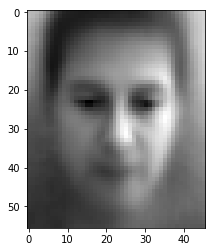

In [6]:
plt.imshow(mean.reshape((h, w)).T, cmap=plt.cm.gray)

## PCA Naive

In [7]:
tracemalloc.start()
start = time.time()

# Compute eigen vectors/values using naive method
Sn = np.dot(X_train_norm.T, X_train_norm)/X_train.shape[0]
eig_values_Sn, eig_vectors_Sn = np.linalg.eig(Sn)

# Sorting
idx_Sn = eig_values_Sn.argsort()[::-1]   
sorted_eig_values_Sn = eig_values_Sn[idx_Sn].real
sorted_eig_vectors_Sn = eig_vectors_Sn[:,idx_Sn].real

print("Computation time : ", time.time()-start)
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 5 ]")
for stat in top_stats[:5]:
    print(stat)

Computation time :  22.719029426574707
[ Top 5 ]
/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1268: size=101 MiB, count=4, average=25.3 MiB
<ipython-input-7-d3f3c4089449>:11: size=101 MiB, count=3, average=33.8 MiB
<ipython-input-7-d3f3c4089449>:5: size=50.6 MiB, count=2, average=25.3 MiB
<ipython-input-7-d3f3c4089449>:10: size=40.4 KiB, count=3, average=13.5 KiB
<ipython-input-7-d3f3c4089449>:9: size=20.3 KiB, count=3, average=6923 B


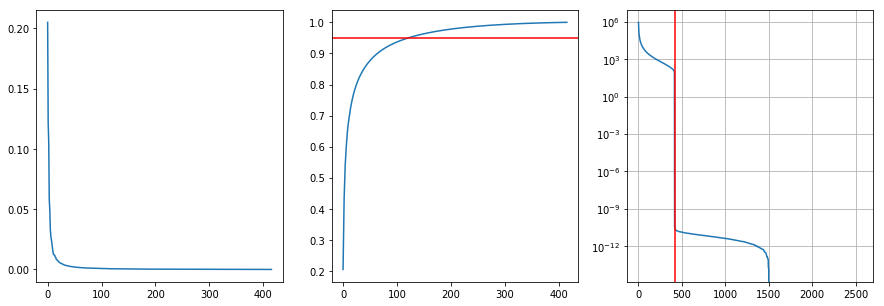

In [8]:
# Display eigen values and scree plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(sorted_eig_values_Sn[:X_train.shape[0]] / np.sum(sorted_eig_values_Sn))
plt.subplot(1,3,2)
plt.plot(np.cumsum(sorted_eig_values_Sn[:X_train.shape[0]]) / np.sum(sorted_eig_values_Sn))
plt.axhline(y=0.95,color='red')
plt.subplot(1,3,3)
plt.semilogy(sorted_eig_values_Sn)
plt.grid()
plt.axvline(x=X_train.shape[0],color='red')

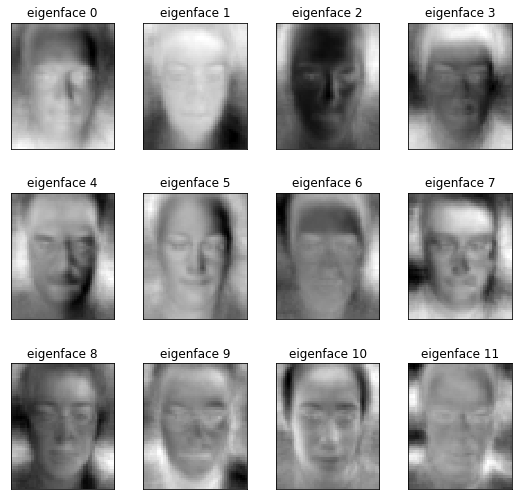

In [9]:
eigenface_titles = ["eigenface %d" % i for i in range(eig_vectors_Sn.shape[0])]
plot_gallery(sorted_eig_vectors_Sn.T.reshape((eig_values_Sn.shape[0], h, w)), eigenface_titles, h, w)

# PCA efficient

In [10]:
tracemalloc.start()
start = time.time()

# Compute eigen vectors/values using efficient method
Se = np.dot(X_train_norm, X_train_norm.T)/X_train.shape[0]
eig_values_Se, eig_vectors_Se = np.linalg.eig(Se)

# Sorting
idx_Se = eig_values_Se.argsort()[::-1]   
sorted_eig_values_Se = eig_values_Se[idx_Se].real
sorted_eig_vectors_Se = eig_vectors_Se[:,idx_Se].real

# Computing real eigenfaces from eigen vectors
eigenfaces_Se_large = np.dot(X_train_norm.T, sorted_eig_vectors_Se)

# Normalise to prevent saturation
maximum = eigenfaces_Se_large.max().real
eigenfaces_Se = eigenfaces_Se_large / maximum

print("Computation time : ", time.time()-start)
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 5 ]")
for stat in top_stats[:5]: print(stat)

Computation time :  0.23041462898254395
[ Top 5 ]
/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1268: size=104 MiB, count=8, average=13.0 MiB
<ipython-input-7-d3f3c4089449>:11: size=101 MiB, count=3, average=33.8 MiB
<ipython-input-7-d3f3c4089449>:5: size=50.6 MiB, count=2, average=25.3 MiB
<ipython-input-10-23012dc3f741>:14: size=8372 KiB, count=3, average=2791 KiB
<ipython-input-10-23012dc3f741>:18: size=8372 KiB, count=2, average=4186 KiB


<BarContainer object of 416 artists>

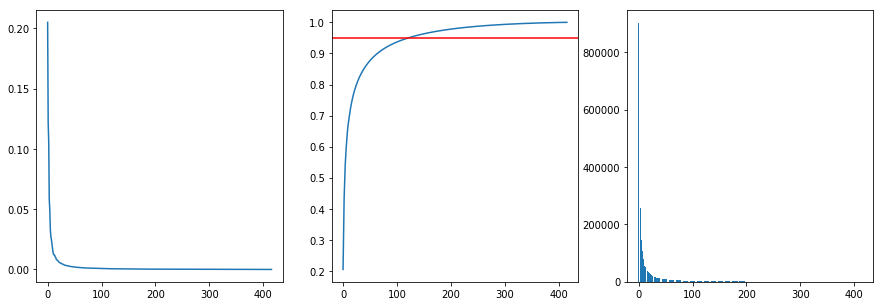

In [11]:
# Display eigen values and scree plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(sorted_eig_values_Se / np.sum(sorted_eig_values_Se))
plt.subplot(1,3,2)
plt.plot(np.cumsum(sorted_eig_values_Se) / np.sum(sorted_eig_values_Se))
plt.axhline(y=0.95,color='red')
plt.subplot(1,3,3)
plt.bar(range(X_train.shape[0]), sorted_eig_values_Se)

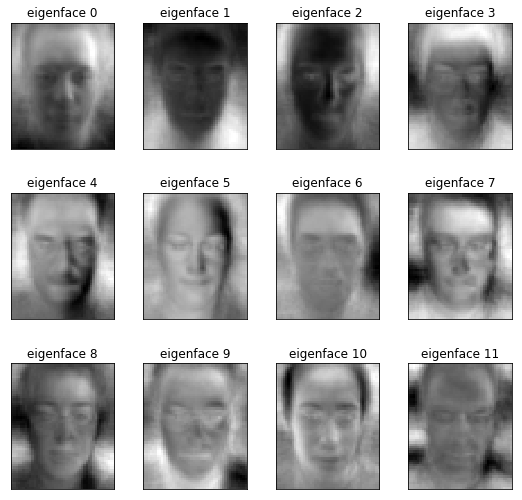

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eig_vectors_Se.shape[0])]
plot_gallery(eigenfaces_Se.T.reshape((eig_vectors_Se.shape[0], h, w)),
             eigenface_titles, h, w)

# Reconstruction

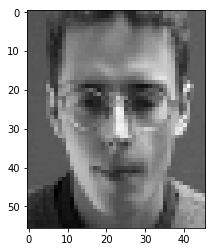

In [13]:
# Random picking up a face in the testing set
face_to_test_idx = np.random.choice(range(X_test.shape[0]))
plt.imshow(X_test[face_to_test_idx].reshape((h, w)).T, cmap=plt.cm.gray)

In [14]:
def project(image, mean, base):
    # Projecting this face on the PCA bases
    norm_image = image - mean
    components=np.zeros(len(base))
    for i in range(len(base)):
        components[i] = np.dot(norm_image, base[i])
    return components

In [15]:
def reconstruct(components, mean, base):
    reconstructed_image = np.zeros(h*w)
    reconstructed_image += mean
    for i in range(len(components)):
        reconstructed_image += components[i] * base[i]
    return reconstructed_image

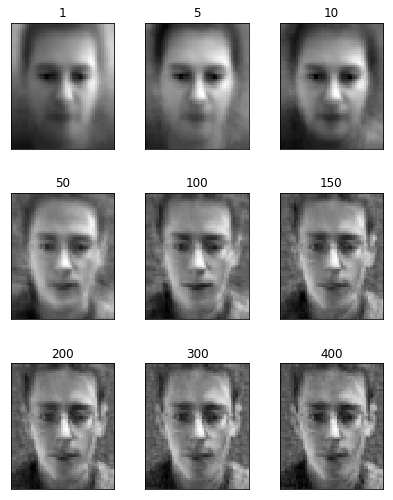

In [16]:
test_dim = [1,5,10,50,100,150,200,300,400]
components = project(X_test[face_to_test_idx], mean, sorted_eig_vectors_Sn.T)
images = np.empty((len(test_dim), h, w))
titles = []
for i, dim in enumerate(test_dim):
    images[i] = reconstruct(components[:dim], mean, sorted_eig_vectors_Sn.T).reshape((h, w))
    titles.append(dim)
plot_gallery(images, titles, h, w, n_row=3, n_col=3)